In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import json
import pdb

from utils import create_dict, create_list, get_data, find_type2_locations, find_type3_locations, find_type4_locations
from utils import applyArtifacts, removeCells, avg_firing, NumpyEncoder, avg_amplitude, nrActiveCells, div_avg_firing, div_avg_amplitude, top_least
from utils import cellID, spindle_locs, search_spindle, spi_inOut_diff, zscore_calculator
from Analyses_ import slo_spi
%config Completer.use_jedi = False

### Input informations

In [2]:
all_address = ['L:/analysis_nima/250520_m18a/Batch_4', 'L:/analysis_nima/290520_m17a/Batch/extracells/Batch_2',
                'L:/analysis_nima/110620_m18b/new/Batch_3', 'L:/analysis_nima/050820_m21a/Batch_4',
                'L:/analysis_nima/030720_m20a/Batch_3', 'L:/analysis_nima/291020_m23a/Batch_2', 
               'L:/analysis_nima/210121_m24a/Batch_1']

# sampling rate for different mice
sfs = [30.995, 30.995, 30.955, 30.995, 30.995, 30.9576, 30.995]

# defining artifacts
custom_artifacts_1 = [[11007,11008,4]]
custom_artifacts_2 = [[11630,11947,0],[12000,12700,0],[4533,5154,14]]
custom_artifacts_3 = []
custom_artifacts_4 = [[1595,1845,0],[4609,4907,0],[7740,7983,0],[13795,14101,0],[16706,16973,0],
             [7266,7501,1],[11912,12219,1],[12703,13203,1],[13730,13909,1],[15097,15559,1],[17277,17519,1],
             [1416,1793,2],[3816,4123,2],[13254,13593,2],[15224,15703,2],[17668,18067,2],
             [7358,7521,3],[10240,10253,3],[13672,13748,3],[17306,17593,3],
             [5505,5939,4],[6222,6231,4],[16760,16820,4],[18450,18573,4],                           
             [1132,1357,7],[8653,8776,7],[9946,10391,7],
             [9068,9323,7],[13589,13623,7],[17394,17547,7],
             [1,140,8],[908,965,8],[7638,7665,8],[8014,8027,8],[14726,14922,8],[18022,18187,8],
             [1912,2381,9],[2920,2923,9],[7767,7819,9],[7864,7997,9],[9876,10197,9],[15206,15545,9],
             [6734,7220,10],[9668,9939,10],
             [8914,9290,11],[9562,9571,11],[12216,12339,11],
             [11492,11553,12],[13898,13919,12],
             [6298,6619,13],[12282,12795,13],[14406,14507,13],[14798,14875,13],
             [1,220,14],[1878,2108,14],[9872,9961,14],
             [4764,4813,15],[5564,5571,15],[15419,15595,15],[16003,16089,15],[16420,16482,15],
             [4240,4403,16],[9975,10077,16],[10274,10275,16],[13228,13451,16],[13805,13939,16],[14620,14664,16],[15764,15857,16],[18430,18537,16],
             [10425,10591,17],[11058,11709,17],[12232,12311,17],[12784,12804,17],[17000,17115,17],
             [10655,10825,18],[11993,12075,18],[12648,12685,18],[16013,16134,18],
             [14466,15015,19],[16876,17009,19],[18398,18573,19],
            [628,958,23],[7822,7976,23],[10298,10435,23],[13899,14241,23],[14466,14537,23],[15773,15848,23],[17664,17925,23],[18291,18426,23],
            [4309,4512,24],[5271,5467,24],[6450,6700,24],[7186,7593,24],
            [460,700,25],[1714,1725,25],[4045,4153,25],[13600,13699,25],
            [4434,4568,26],[5984,6167,26],
            [1770,1831,27],[4060,4064,27],
            [2000,2193,28],[11098,11334,28],
            [5921,5997,30],[8200,8210,30],[9189,9191,30],
            [686,852,31],[13375,13543,31],[14059,14334,31],[15808,15883,31],
            [10760,10800,33],[13942,14061,33],[17672,17738,33],
            [10576,10604,41]]
custom_artifacts_5 = [[3928,3971,0],[4584,4656,0],[7001,7119,0],[14144,14230,0],[14466,14501,0],[15591,15593,0],
            [559,603,1],[2187,2214,1],[3999,4054,1],[11749,11790,1],[17785,17839,1],
            [3403,3491,2],[11936,11980,2],
            [1397,1465,3],[13881,13889,3],[14510,14526,3],[18377,18441,3],                                                                                           
            [2585,2635,4], [6722,6771,4],[10867,10897,4],[16543,16615,4],
            [740,825,5],[2026,2113,5],[13025,13051,5],
            [798,863,6],[1795,1857,6],[3949,3980,6],[5190,5244,6],[10480,10547,6],[11219,11301,6],[12144,12191,6],[12690,12747,6],
            [1343,1441,7],[2618,2684,7],[2709,2713,7],[3427,3496,7],[4138,4185,7],[4532,4567,7],[5694,8768,7],[9513,9562,7],[12510,12644,7],[15000,15073,7],
            [96,140,8],[4175,4258,8],
            [409,564,9],[13291,13497,9],[16520,18573,9],
            [9968,10026,10],[14269,14335,10],[16569,16616,10],
            [404,557,11],[12553,12649,11],
            [503,598,13],[2832,2889,13],[13151,13218,13],[18276,18343,13],
            [769,954,14],[980,1001,14],[2324,2389,14],[4286,4297,14],
            [3349,3447,15],[6128,6221,15],
            [8475,8543,16],
            [9792,9840,17],
            [2984,3007,20],[4131,4183,20],[5025,5042,20],[6330,6355,20],[11818,11893,20],
            [6760,6875,21],
            [12871,12895,28],[13645,13667,28],[14232,14319,28],[14837,14849,28],[15521,15542,28],[16421,16445,28],[17032,17040,28]]
custom_artifacts_6 = [[8863,9191,4],
           [5389,5393,7],[5575,5607,7],[5754,5755,7],[5798,6000,7],
            [11050,11070,10],[12260,12280,10],
            [15125,15290,12],[16420,18160,10],
            [13280,13340,13],
            [8,23,15],[92,94,15],[481,505,15],
            [10035,10500,20],[11024,11044,20],
            [5794,5800,21],
            [3501,3507,22]]
custom_artifacts_7 = [[0,3418,0],[13116,13507,0],[14502,14872,0],
              [8000,9000,2],
              [1828,2638,3],[8631,12630,3],
              [1497,1988,4],[16470,17270,4],
              [5113,8239,5],                                                                                         
              [2322,2978,6],
              [12460,14890,7],
              [15600,16060,10],
              [4231,4848,11],[6434,6909,11],[9110,11550,11],
              [11890,12380,12],
              [8410,8820,13],
              [3026,3515,14],[13810,14170,14],
              [10910,12010,15]]  
artifacts = [custom_artifacts_1, custom_artifacts_2, custom_artifacts_3,
                custom_artifacts_4, custom_artifacts_5, custom_artifacts_6, custom_artifacts_7]

# cell removal 
remove_cell_1 = []
remove_cell_2 = []
remove_cell_3 = [62,63,64,65,66,67,68,69,70,80,81,160,161,162,163,164,167,194,195,202,203,204]
remove_cell_4 = [13,53,55,57,79,84,85,86,95,99,112,141,144,147,153,177,178,183,184,188,189,191,196,197,198,199,202,219,226,234,235]
remove_cell_5 = []
remove_cell_6 = [66,84,85,86]
remove_cell_7 = []
remove_cells = [remove_cell_1, remove_cell_2, remove_cell_3,
              remove_cell_4, remove_cell_5, remove_cell_6, remove_cell_7]
# mouse name
miceName = ['250520_m18a', '290520_m17a', '110620_m18b', '050820_m21a', '030720_m20a', '291020_m23a', '210121_m24a']

# mouse name indcies
mouse_index = {miceName[0]:0, miceName[1]:1, miceName[2]:2, miceName[3]:3, miceName[4]:4, miceName[5]:5, miceName[6]:6}


# saving figure 
save_fig = True # or False
fig_save_add = ''


# saving dataframes
save_file = True # or False
file_save_add = ''

### Creating base data structure and loading data and hypno to it
####    If ncessary first apply artifact on data or remove cells then create data structure

In [3]:
apply_artifact = True
rmCell = True

data_list = []
for address, sf, mouse_name, artifact, remove_cell in zip(all_address, sfs, miceName, artifacts, remove_cells):
    
    #clear and read data
    data = []; hypno = []
    data, hypno = get_data(address = address, sf = sf)
    
    if apply_artifact:
        data = applyArtifacts(data=data, artifacts=artifact)
    
    if rmCell:
        data = removeCells(data=data, cells = remove_cell)
    
    # creat per mouse list
    data_list.extend(create_list(data = data, hypno = hypno, mouseName = mouse_name, 
                                 sf = sf, apply_artifact=apply_artifact, removeCell=rmCell))

Your entered path is L:/analysis_nima/250520_m18a/Batch_4
All files in the given path 

['unit01.mat', 'unit02.mat', 'unit03.mat', 'unit04.mat', 'unit05.mat', 'unit06.mat', 'unit07.mat', 'unit08.mat', 'unit09.mat', 'unit10.mat', 'unit11.mat', 'unit12.mat', 'unit13.mat', 'unit14.mat', 'unit15.mat', 'unit16.mat', 'unit17.mat', 'unit18.mat', 'unit19.mat', 'unit20.mat', 'unit21.mat', 'unit22.mat', 'unit23.mat', 'unit24.mat', 'unit25.mat', 'unit26.mat', 'unit27.mat', 'unit28.mat', 'unit29.mat', 'unit30.mat', 'unit31.mat', 'unit32.mat', 'unit33.mat', 'unit34.mat', 'unit35.mat', 'unit36.mat', 'unit37.mat', 'unit38.mat', 'unit39.mat', 'unit40.mat', 'unit41.mat', 'unit42.mat', 'unit43.mat', 'unit44.mat', 'unit45.mat']  Number of all files 45
Data are loaded 

Start reading units 

unit length is 600 sec, data length is 18597 samples, number of cells are 236 

Finished reading units 

Start reading hypno files 

Finished reading hypno 

Location-Time information
data and hypno shapes in file L:/

### Adding analyses as dictionary key, value pairs

In [4]:
# add average firing rate to the dictionary
[data_dict.update({'avg_firing_perSecond':avg_firing(data = data_dict['data'], 
                                                            sf=data_dict['samplingRate'])}) for data_dict in data_list];

In [5]:
# add average amplitude to the dictionary
[data_dict.update({'avg_amplitude':avg_amplitude(data = data_dict['data'])}) for data_dict in data_list];

c:\Users\admin\Sleep_Pipeline_Notebooks\Analysis_all_mice\SleepAnalyses\utils.py:229: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.where(data>0 , data, np.nan), axis = 0)


In [6]:
# zscore normalization of avg firing rate. Normalization is applied per cell for each individual mouse separately
data_list = zscore_calculator(dataBase = data_list, mouse_name_list=miceName, variable = "frequency")

# zscore normalization of avg amplitude. Normalization is applied per cell for each individual mouse separately
data_list = zscore_calculator(dataBase = data_list, mouse_name_list=miceName, variable = "amplitude")


  0%|          | 0/7 [00:00<?, ?it/s]c:\Users\admin\Sleep_Pipeline_Notebooks\Analysis_all_mice\SleepAnalyses\utils.py:428: RuntimeWarning: Mean of empty slice
  mouse_zscore_info.append({"mouseName":mouse, "nanmean": np.nanmean(np.stack(mouse_avg), axis = 0), "nanstd": np.nanstd(np.stack(mouse_avg), axis = 0)})
C:\Users\admin\Anaconda3\envs\sleep_project\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  0%|          | 0/2018 [00:00<?, ?it/s]c:\Users\admin\Sleep_Pipeline_Notebooks\Analysis_all_mice\SleepAnalyses\utils.py:435: RuntimeWarning: invalid value encountered in true_divide
  dict.update({"avg_firing_perSecond_zscore": (dict["avg_firing_perSecond"] - info["nanmean"]) / info["nanstd"]})
  0%|          | 0/7 [00:00<?, ?it/s]c:\Users\admin\Sleep_Pipeline_Notebooks\Analysis_all_mice\SleepAnalyses\utils.py:466: RuntimeWarning: Mean of empty slice
  mouse_zscore_info.appe

In [7]:
# add top and least firing rate 
fraction = 20

#top
[data_dict.update({'top' + str(fraction) + '_avg_firing':top_least(data=data_dict['avg_firing_perSecond'], 
                                                                   prc = fraction, top = True)}) for data_dict in data_list];

#least
[data_dict.update({'least' + str(fraction) + '_avg_firing':top_least(data=data_dict['avg_firing_perSecond'], 
                                                                   prc = fraction, top = False)}) for data_dict in data_list];


#top-zscore
[data_dict.update({'top' + str(fraction) + '_avg_firing_zscore':top_least(data=data_dict['avg_firing_perSecond_zscore'], 
                                                                   prc = fraction, top = True)}) for data_dict in data_list];

#least-zscore
[data_dict.update({'least' + str(fraction) + '_avg_firing_zscore':top_least(data=data_dict['avg_firing_perSecond_zscore'], 
                                                                   prc = fraction, top = False)}) for data_dict in data_list];

In [8]:
# add top and least amplitude 
fraction = 20

#top
[data_dict.update({'top' + str(fraction) + '_amplitude':top_least(data=data_dict['avg_amplitude'], 
                                                                   prc = fraction, top = True)}) for data_dict in data_list];

#least
[data_dict.update({'least' + str(fraction) + '_amplitude':top_least(data=data_dict['avg_amplitude'], 
                                                                   prc = fraction, top = False)}) for data_dict in data_list];


#top-zscore
[data_dict.update({'top' + str(fraction) + '_amplitude_zscore':top_least(data=data_dict['avg_amplitude_zscore'], 
                                                                   prc = fraction, top = True)}) for data_dict in data_list];

#least-zscore
[data_dict.update({'least' + str(fraction) + '_amplitude_zscore':top_least(data=data_dict['avg_amplitude_zscore'], 
                                                                   prc = fraction, top = False)}) for data_dict in data_list];

In [9]:
# add divided average firing rate to the dictionary
[data_dict.update({'div_avg_firing_perSecond':div_avg_firing(data = data_dict['data'], 
                                                             sf=data_dict['samplingRate'], 
                                                             n = 3)}) for data_dict in data_list];

# zscore normalization of avg firing rate. Normalization is applied per cell for each individual mouse separately
data_list = zscore_calculator(dataBase = data_list, mouse_name_list=miceName, variable = "frequency", divided_data=True)

  0%|          | 0/7 [00:00<?, ?it/s]c:\Users\admin\Sleep_Pipeline_Notebooks\Analysis_all_mice\SleepAnalyses\utils.py:447: RuntimeWarning: Mean of empty slice
  mouse_zscore_info.append({"mouseName":mouse, "nanmean": np.nanmean(np.vstack(mouse_avg), axis = 0), "nanstd": np.nanstd(np.vstack(mouse_avg), axis = 0)})
  0%|          | 0/2018 [00:00<?, ?it/s]c:\Users\admin\Sleep_Pipeline_Notebooks\Analysis_all_mice\SleepAnalyses\utils.py:454: RuntimeWarning: invalid value encountered in true_divide
  dict.update({"div_avg_firing_perSecond_zscore": [(el - info["nanmean"]) / info["nanstd"] for el in dict["div_avg_firing_perSecond"]]})
100%|██████████| 2018/2018 [00:00<00:00, 74736.92it/s]


In [10]:
# add divided average firing rate to the dictionary (n subdata)
[data_dict.update({'div_avg_amplitude':div_avg_amplitude(data = data_dict['data'], n=3)}) for data_dict in data_list];

# zscore normalization of avg amplitude. Normalization is applied per cell for each individual mouse separately
data_list = zscore_calculator(dataBase = data_list, mouse_name_list=miceName, variable = "amplitude", divided_data= True)

  0%|          | 0/7 [00:00<?, ?it/s]c:\Users\admin\Sleep_Pipeline_Notebooks\Analysis_all_mice\SleepAnalyses\utils.py:484: RuntimeWarning: Mean of empty slice
  mouse_zscore_info.append({"mouseName":mouse, "nanmean": np.nanmean(np.vstack(mouse_avg), axis = 0), "nanstd": np.nanstd(np.vstack(mouse_avg), axis = 0)})
  0%|          | 0/2018 [00:00<?, ?it/s]c:\Users\admin\Sleep_Pipeline_Notebooks\Analysis_all_mice\SleepAnalyses\utils.py:491: RuntimeWarning: invalid value encountered in true_divide
  dict.update({"div_avg_amplitude_zscore": [(el - info["nanmean"]) / info["nanstd"] for el in dict["div_avg_amplitude"]]})
100%|██████████| 2018/2018 [00:00<00:00, 77611.05it/s]


In [11]:
# add epoch duration in sample
[data_dict.update({'epochDuration': data_dict['data'].shape[0]}) for data_dict in data_list];

In [12]:
# add nr of active cell per epoch
[data_dict.update({'nrActiveCells': nrActiveCells(data = data_dict['avg_amplitude'])}) for data_dict in data_list];

In [13]:
# add nr of total cells per epoch
[data_dict.update({'nrTotalCells': data_dict['data'].shape[1]}) for data_dict in data_list];

In [14]:
# adding location of type2 pattern to the dictionaries


# type2: 1 epoch is first element of the pattern
#        2 epoch is second element of the pattern
#        0 epoch is not involved in the pattern


# finding locations (each location is the location of first element of the pattern)
type2_locations = find_type2_locations(dictLists=data_list, pattern=[-2, -3], 
                                       cond1_min= 900, cond1_max=10000, 
                                       cond2_min=900, cond2_max=10000)



[data_dict.update({'type2': 0}) for data_dict in data_list]

for i, data_dict in enumerate(data_list):
    if i in type2_locations:
        data_dict.update({'type2':1})
        data_list[i+1].update({'type2':2})

In [15]:
# adding location of type3 pattern to the dictionaries


# type2: 1 epoch is first element of the pattern
#        2 epoch is second element of the pattern
#        3 epoch is third element of the pattern
#        0 epoch is not involved in the pattern


# finding locations (each location is the location of first element of the pattern)
type3_locations = find_type3_locations(dictLists=data_list, pattern=[-2, -3, -2], 
                                       cond1_min=900, cond1_max=10000, 
                                       cond2_min=900, cond2_max=10000, 
                                       cond3_min=900, cond3_max=10000)



[data_dict.update({'type3': 0}) for data_dict in data_list]

for i in range(type3_locations.shape[0]):
    
    # put all pattern locations in the first element of the pattern
    data_list[type3_locations[i,0]].update({'type3':type3_locations[i,:]})
    

In [16]:
# adding location of type4 pattern to the dictionaries


# type2: 1 epoch is first element of the pattern
#        2 epoch is second element of the pattern
#        3 epoch is third element of the pattern
#        0 epoch is not involved in the pattern


# finding locations (each location is the location of first element of the pattern)
type4_locations = find_type4_locations(dictLists=data_list, pattern=[0, -2, 0, -2], 
                                       cond1_min= 900, cond1_max=10000, 
                                       cond2_min=900, cond2_max=10000, 
                                       cond3_min=900, cond3_max=10000,
                                       cond4_min=900, cond4_max=10000)



[data_dict.update({'type4': 0}) for data_dict in data_list]

for i in range(type4_locations.shape[0]):
    
    # put all pattern locations in the first element of the pattern
    data_list[type4_locations[i,0]].update({'type4':type4_locations[i,:]})
    

In [17]:
# top x % based RTM issue for type2/type3 patterns

# type2_avgFiring_RTM: normalized firing rate of 2 type2 epochs (concatinating 2 epochs)
# type3_avgFiring_RTM: normalized firing rate per cell taking all 3 type3 epochs together (concatinating 3 epochs)

# type2_topx%_RTM: top x% of normalized firing rate cells based on type2 (taking average from above-it always comes to the first epoch)
# type3_topx%_RTM: top x% of normalized firing rate cells based on type3 (taking average from above-it alwaves comes to the first epoch)

# initializing values
[data_dict.update({"type2_avgFiring_RTM": None}) for data_dict in data_list]
[data_dict.update({"type3_avgFiring_RTM": None}) for data_dict in data_list]

[data_dict.update({f"type2_top{fraction}%_RTM": None}) for data_dict in data_list]
[data_dict.update({f"type3_top{fraction}%_RTM": None}) for data_dict in data_list]

[data_dict.update({f"type2_least{fraction}%_RTM": None}) for data_dict in data_list]
[data_dict.update({f"type3_least{fraction}%_RTM": None}) for data_dict in data_list]

print("Start main analyses\nRun 1")

for i, epoch in enumerate(data_list):
    
    # check first type2 epoch
    if epoch["type2"] == 1:
        # calculate type2_avgFiring_RTM
        epoch["type2_avgFiring_RTM"] = avg_firing(data = np.vstack([epoch["data"], data_list[i+1]["data"]]), 
                                                  sf = epoch["samplingRate"])
        
    if not isinstance(epoch["type3"], int):
        # calculate type3_avgFiring_RTM
        epoch["type3_avgFiring_RTM"] = avg_firing(data = np.vstack([data_list[epoch["type3"][0]]["data"], 
                                                                    data_list[epoch["type3"][1]]["data"], 
                                                                    data_list[epoch["type3"][2]]["data"]]), 
                                                  sf = epoch["samplingRate"])

print("Run 2")
for i, epoch in enumerate(data_list):
    
    # check first type2 epoch
    if epoch["type2"] == 1:
        # calculate type2_topx%_RTM
        epoch[f"type2_top{fraction}%_RTM"] = top_least(data = epoch["type2_avgFiring_RTM"], prc = fraction, top = True)
        epoch[f"type2_least{fraction}%_RTM"] = top_least(data = epoch["type2_avgFiring_RTM"], prc = fraction, top = False)
        
    if not isinstance(epoch["type3"], int):
        # calculate type3_topx%_RTM
        epoch[f"type3_top{fraction}%_RTM"] = top_least(data = epoch["type3_avgFiring_RTM"], prc = fraction, top = True)
        epoch[f"type3_least{fraction}%_RTM"] = top_least(data = epoch["type3_avgFiring_RTM"], prc = fraction, top = False)


Start main analyses
Run 1
Run 2


### Spindle/Slow Oscillations

In [18]:
spi_slow_use = True

# main file adrress (Niels data)
spi_slow_file_address = ['L:/analysis_nima/spindles/m18a.mat', 'L:/analysis_nima/spindles/m17a.mat', 
                        'L:/analysis_nima/spindles/m18b.mat', 'L:/analysis_nima/spindles/m21a.mat', 
                        'L:/analysis_nima/spindles/m20a.mat', 'L:/analysis_nima/spindles/m23a.mat', 
                        'L:/analysis_nima/spindles/m24a.mat']
# location of events in selected file (can be spindle or slow oscillation)
spi_slow_data_loc = 'Results/spi/events'

# start and end index (in spindle is 0-1 but in slow oscillation is 1-2)
spi_slow_start_index = 0
spi_slow_end_index = 1

# channel number we want to select ([0,0] or [0,1] - frontal or parietal)
spi_slow_channel_nr = [0,0]

# address for files with unit information
spi_slow_start_end_unit_address = ['L:/analysis_nima/250520_m18a/hypno_unit_sec_m18a.csv', 
                                   'L:/analysis_nima/290520_m17a/Batch/hypno_unit_sec_m17a.csv', 
                                   'L:/analysis_nima/110620_m18b/hypno_unit_sec_m18b.csv', 
                                   'L:/analysis_nima/050820_m21a/hypno_unit_sec_m21a.csv', 
                                   'L:/analysis_nima/030720_m20a/hypno_unit_sec_m20a.csv', 
                                   'L:/analysis_nima/291020_m23a/hypno_unit_sec_m23a.csv', 
                                   'L:/analysis_nima/210121_m24a/hypno_unit_sec_m24a.csv']


# Binary indicator to do coupled analysis or take all spindles (True only for spindles. Must be False for slow oscillation)
spi_slow_apply_couple = True

# When apply_couple is True this is indicator to select only coupled spindles (True) or non-coupled spindles (False)
spi_slow_couple_analysis = False

# channels number to select from coupled spindles ([0,0] or [0,1] - frontal or parietal)
spi_slow_couple_channel = [0,0]

# location of coupled spindles indices
spi_slow_couple_address = '/Results/slospi/spiIndx'

In [19]:
spi_slo_art_all = []
for i in range(len(spi_slow_file_address)):
    slow_osc = slo_spi(file_address=spi_slow_file_address[i], 
                       data_location=spi_slow_data_loc, channel_nr=spi_slow_channel_nr, 
                       start_index=spi_slow_start_index, end_index=spi_slow_end_index, 
                       start_end_file_add=spi_slow_start_end_unit_address[i], 
                       file_length= int(3e7), elec_sample=1000, unit_length=600, ca_fs=sfs[i], 
                       coupled = {'apply':spi_slow_apply_couple, 'address':spi_slow_couple_address, 
                                  'channel':spi_slow_couple_channel, 'cp':spi_slow_couple_analysis})
    print(f'running file {spi_slow_file_address[i]}')
    spi_slo_art_all.append(slow_osc.slo_spi_list())

running file L:/analysis_nima/spindles/m18a.mat
running file L:/analysis_nima/spindles/m17a.mat
running file L:/analysis_nima/spindles/m18b.mat
running file L:/analysis_nima/spindles/m21a.mat
running file L:/analysis_nima/spindles/m20a.mat
running file L:/analysis_nima/spindles/m23a.mat
running file L:/analysis_nima/spindles/m24a.mat


In [20]:
# adding spindle/oscillation data to database

# initializing data and indices
[data_dict.update({'spi_osc_data': []}) for data_dict in data_list];
[data_dict.update({'spi_osc_indices': []}) for data_dict in data_list];
[data_dict.update({'spi_osc_NOTdata': []}) for data_dict in data_list];
[data_dict.update({'spi_osc_NOTindices': []}) for data_dict in data_list];

# running analyses (data)
[data_dict.update({'spi_osc_data': search_spindle(data_spindle=spi_slo_art_all, Dict=data_dict, mouse_index=mouse_index)[0]}) for data_dict in data_list];

# running analyses (indices)
[data_dict.update({'spi_osc_indices': search_spindle(data_spindle=spi_slo_art_all, Dict=data_dict, mouse_index=mouse_index)[1]}) for data_dict in data_list];

# running analyses (NOTdata: data outside of spindle range)
[data_dict.update({'spi_osc_NOTdata': search_spindle(data_spindle=spi_slo_art_all, Dict=data_dict, mouse_index=mouse_index)[2]}) for data_dict in data_list if len(data_dict['spi_osc_data'])];


# running analyses (NOTindices)
[data_dict.update({'spi_osc_NOTindices': search_spindle(data_spindle=spi_slo_art_all, Dict=data_dict, mouse_index=mouse_index)[3]}) for data_dict in data_list];

In [21]:
# adding avg_firing rate for spi/osc and not spi/osc time periods

# initializing
[data_dict.update({'spi_osc_data_avgFiring': []}) for data_dict in data_list];
[data_dict.update({'spi_osc_NOTdata_avgFiring': []}) for data_dict in data_list];

[data_dict.update({'spi_osc_data_avgAmplitude': []}) for data_dict in data_list];
[data_dict.update({'spi_osc_NOTdata_avgAmplitude': []}) for data_dict in data_list];

# calculating average

[data_dict.update({'spi_osc_data_avgFiring': avg_firing(data = np.vstack(data_dict['spi_osc_data']), 
                                                            sf=data_dict['samplingRate'])}) for data_dict in data_list if len(data_dict['spi_osc_data'])];

[data_dict.update({'spi_osc_NOTdata_avgFiring': avg_firing(data = data_dict['spi_osc_NOTdata'], 
                                                            sf=data_dict['samplingRate'])}) for data_dict in data_list if len(data_dict['spi_osc_NOTdata'])];

[data_dict.update({'spi_osc_data_avgAmplitude': avg_amplitude(data = np.vstack(data_dict['spi_osc_data']))}) for data_dict in data_list if len(data_dict['spi_osc_data'])];

[data_dict.update({'spi_osc_NOTdata_avgAmplitude': avg_amplitude(data = data_dict['spi_osc_NOTdata'])}) for data_dict in data_list if len(data_dict['spi_osc_NOTdata'])];

In [33]:
# add top and least firing rate 
fraction = 20

#top
[data_dict.update({'spindle_top' + str(fraction) + '_diff_firing':top_least(data=spi_inOut_diff(x = data_dict['spi_osc_data_avgFiring'], 
                                                                                                y = data_dict['spi_osc_NOTdata_avgFiring']), 
                                                                   prc = fraction, top = True, positive=True)}) for data_dict in data_list if len(data_dict['spi_osc_data'])];

#least
[data_dict.update({'spindle_least' + str(fraction) + '_diff_firing':top_least(data=spi_inOut_diff(x = data_dict['spi_osc_data_avgFiring'], 
                                                                                                  y = data_dict['spi_osc_NOTdata_avgFiring']), 
                                                                   prc = fraction, top = False)}) for data_dict in data_list if len(data_dict['spi_osc_data'])];

In [23]:
# number of spindle active cells per epoch

# initialize
[data_dict.update({'nrSpindleActiveCells': []}) for data_dict in data_list];

# calculate 
[data_dict.update({'nrSpindleActiveCells': len(np.where(~np.isnan(data_dict["spi_osc_data_avgFiring"]))[0])}) for data_dict in data_list if len(data_dict["spi_osc_data_avgFiring"])];

In [24]:
# normalized (to total active cells in epoch-in percentage) fraction of spindle active cells per epoch

# initialize
[data_dict.update({'norm_SpindleActiveCells': []}) for data_dict in data_list];

# calculate 
[data_dict.update({'norm_SpindleActiveCells': (len(np.where(~np.isnan(data_dict["spi_osc_data_avgFiring"]))[0]) / data_dict["nrActiveCells"]) * 100}) for data_dict in data_list if len(data_dict["spi_osc_data_avgFiring"])];

In [25]:
# normalized (to total active cells in epoch-in percentage) fraction of spindle active cells per epoch

# initialize
[data_dict.update({'normTototal_SpindleActiveCells': []}) for data_dict in data_list];

# calculate 
[data_dict.update({'normTototal_SpindleActiveCells': (len(np.where(~np.isnan(data_dict["spi_osc_data_avgFiring"]))[0]) / data_dict["nrTotalCells"]) * 100}) for data_dict in data_list if len(data_dict["spi_osc_data_avgFiring"])];

In [115]:
############################################################################################
############################################################################################

In [34]:
# plotting average firing rate 

df_nr_spindle_active_cells = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if indDict['nrSpindleActiveCells']:
        df_nr_spindle_active_cells = df_nr_spindle_active_cells.append(pd.DataFrame({'state':[indDict['hypnoState']], 
                                                                   'nr_active_cells':[indDict['nrSpindleActiveCells']], 
                                                                   'norm_active_cells':[indDict['norm_SpindleActiveCells']],
                                                                   'normTototal_active_cells':[indDict['normTototal_SpindleActiveCells']],
                                                                   'nr_unit':[indDict['unitNr']], 
                                                                   'name':indDict['mouseName']}), ignore_index = True)


In [35]:
df_nr_spindle_active_cells

,state,nr_active_cells,norm_active_cells,normTototal_active_cells,nr_unit,name
0,-2,9,10.465116,3.813559,7,250520_m18a
1,-2,26,17.687075,11.016949,10,250520_m18a
2,-2,6,11.320755,2.542373,10,250520_m18a
3,-2,2,2.105263,0.847458,11,250520_m18a
4,-2,1,1.562500,0.423729,11,250520_m18a
...,...,...,...,...,...,...
585,-2,7,9.459459,4.895105,25,210121_m24a
586,-2,25,29.069767,17.482517,26,210121_m24a
587,-2,6,8.571429,4.195804,26,210121_m24a
588,-2,12,16.901408,8.391608,26,210121_m24a


In [ ]:
df_nr_spindle_active_cells.groupby(["name", "state"]).agg(np.nanmedian)

nr_active_cells  norm_active_cells  \
name        state                                       
030720_m20a -2                13.0          13.636364   
050820_m21a -2                12.0          11.250000   
110620_m18b -3                 1.0           0.714286   
            -2                17.5          13.811277   
             0                 1.0           7.142857   
210121_m24a -2                 6.0          10.485348   
             0                 1.0           3.125000   
250520_m18a -3                22.0          13.173653   
            -2                14.5          11.215933   
             0                 1.0           2.500000   
290520_m17a -3                10.0           5.721230   
            -2                10.0           8.889377   
             0                 3.5           5.769231   
291020_m23a -2                 4.0           9.523810   

                   normTototal_active_cells  nr_unit  
name        state                                     
030720_m20a -2                     7.027027     15.0  
050820_m21a -2                     5.853659     28.0  
110620_m18b -3                     0.510204      6.0  
            -2                     8.928571     12.0  
             0                     0.510204     10.0  
210121_m24a -2                     4.195804     16.0  
             0                     0.699301      0.0  
250520_m18a -3                     9.322034     37.0  
            -2                     6.144068     29.0  
             0                     0.423729     37.0  
290520_m17a -3                     3.401361     26.0  
            -2                     3.401361     20.0  
             0                     1.190476     23.5  
291020_m23a -2                     4.819277     14.0

In [ ]:
df_nr_spindle_active_cells.groupby(["name", "state"]).count()

nr_active_cells  norm_active_cells  \
name        state                                       
030720_m20a -2                  75                 75   
050820_m21a -2                 101                101   
110620_m18b -3                   1                  1   
            -2                 106                106   
             0                   1                  1   
210121_m24a -2                  84                 84   
             0                   1                  1   
250520_m18a -3                   1                  1   
            -2                  66                 66   
             0                   3                  3   
290520_m17a -3                   2                  2   
            -2                  84                 84   
             0                   2                  2   
291020_m23a -2                  63                 63   

                   normTototal_active_cells  nr_unit  
name        state                                     
030720_m20a -2                           75       75  
050820_m21a -2                          101      101  
110620_m18b -3                            1        1  
            -2                          106      106  
             0                            1        1  
210121_m24a -2                           84       84  
             0                            1        1  
250520_m18a -3                            1        1  
            -2                           66       66  
             0                            3        3  
290520_m17a -3                            2        2  
            -2                           84       84  
             0                            2        2  
291020_m23a -2                           63       63

In [ ]:

if save_file:
    df_nr_spindle_active_cells.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/spindle_active_cells/spindle_active.csv')

### Number of cells active during spindle/SO

(-5.0, 80.0)

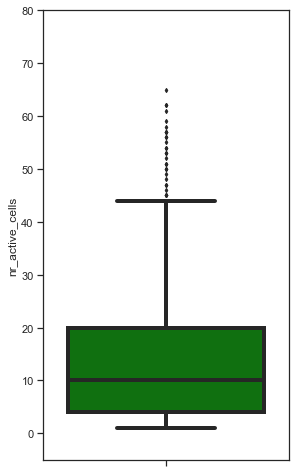

In [36]:
# for all data
#sns.histplot(data = df_nr_spindle_active_cells[df_nr_spindle_active_cells.state == -2], 
           #  x = "nr_active_cells", stat='density', binwidth = 1)
sns.set(rc={'figure.figsize':(4.4,8.27)})
sns.set_style("ticks")
sns.boxplot(data = df_nr_spindle_active_cells[df_nr_spindle_active_cells.state == -2], 
             y = "nr_active_cells", fliersize=3,linewidth=4,palette=['green'])
plt.ylim(-5,80)

#if save_fig:
 #   plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/spindle_active_cells/awake_so_active_cells.pdf', dpi=600, format='pdf')

In [ ]:

sns.histplot(data = df_nr_spindle_active_cells[df_nr_spindle_active_cells.state == -2], 
             x = "norm_active_cells", stat='density', binwidth = 1)
if save_fig:
    plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/spindle_active_cells/spindle_active_norm_cells_sws.pdf', dpi=300, format='pdf')

# Plotting of analyses

### Spindle/Slow Oscillation

#### Frequency Type 3 active cells

<AxesSubplot:xlabel='nr_active_cells', ylabel='Density'>

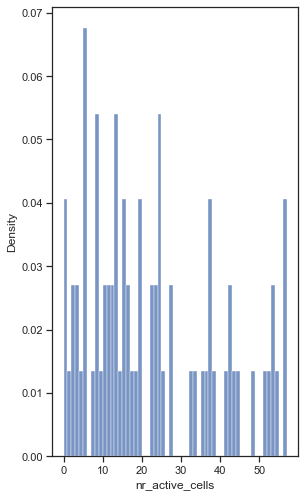

In [ ]:
sns.histplot(data = df_spindle_firing[df_spindle_firing.Pattern==1], x = "nr_active_cells", 
            stat = 'density', binwidth=1)
#if save_fig:
 #   plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/spindle_active_cells/spindle_active_cells_sws_triplet3.pdf', dpi=300, format='pdf')

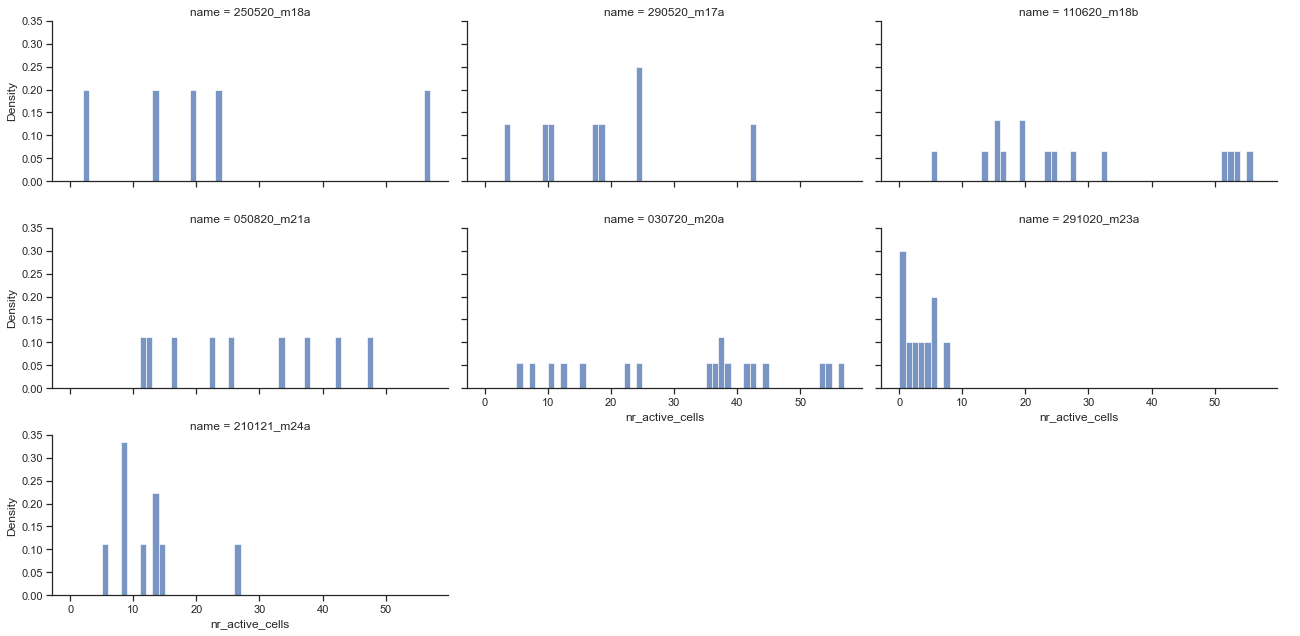

In [ ]:
myGrid = sns.FacetGrid(data=df_spindle_firing[df_spindle_firing.Pattern==1], 
                       col='name', col_wrap=3, aspect=2)
myplot = myGrid.map(sns.histplot, 'nr_active_cells',binwidth=1, stat = 'density')
myplot.add_legend()
#if save_file:
 #   df_spindle_firing[df_spindle_firing.Pattern==1].to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type3_fr/Type3_fr_based_on_top20%_divided_thirds_slo_active.csv')
#if save_fig:
    #plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/spindle_active_cells/slo_active_cells_sws_triplet3_all_mice.pdf', dpi=300, format='pdf')

### Frequency not divided

In [44]:
##frequency without levels

# plotting average firing rate 

df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (not isinstance(indDict['type3'], int)) and (len(indDict['spi_osc_data'])):
        for ii in range(3):
            try:
                df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'FiringRate':[np.nanmean(data_list[indDict['type3'][ii]]['avg_firing_perSecond'][data_list[indDict['type3'][0]]['spindle_top20_diff_firing'][0]])], 
                                                                    'name':indDict['mouseName'], 
                                                                    'Pattern': ii + 1, 
                                                                    'epochID': i}), ignore_index = True)
            except:
                print(f"epoch {i} doesn't have any spindle active cells")
    

C:\Users\admin\AppData\Local\Temp/ipykernel_10088/403509073.py:12: RuntimeWarning: Mean of empty slice
  df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'FiringRate':[np.nanmean(data_list[indDict['type3'][ii]]['avg_firing_perSecond'][data_list[indDict['type3'][0]]['spindle_top20_diff_firing'][0]])],


epoch 1662 doesn't have any spindle active cells
epoch 1662 doesn't have any spindle active cells
epoch 1662 doesn't have any spindle active cells
epoch 1753 doesn't have any spindle active cells
epoch 1753 doesn't have any spindle active cells
epoch 1753 doesn't have any spindle active cells
epoch 1765 doesn't have any spindle active cells
epoch 1765 doesn't have any spindle active cells
epoch 1765 doesn't have any spindle active cells


C:\Users\admin\AppData\Local\Temp/ipykernel_10088/2447521736.py:4: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_temp = df_spindle_firing.melt(id_vars=['name', 'Pattern', 'epochID'], var_name='subEpoch', value_name='FiringRate')


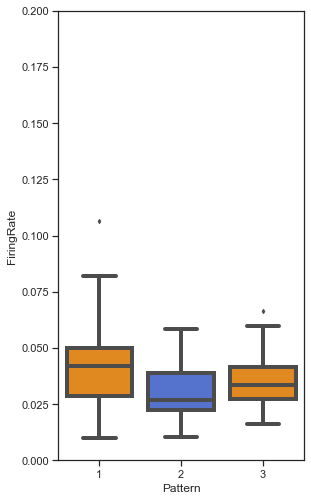

In [45]:
### Boxplot
save_fig = 0
df_temp = pd.DataFrame()
df_temp = df_spindle_firing.melt(id_vars=['name', 'Pattern', 'epochID'], var_name='subEpoch', value_name='FiringRate')

sns.set(rc={'figure.figsize':(4.4,8.27)})
sns.set_style("ticks")
#g=sns.boxplot(x="Pattern", y="FiringRate",dodge=False,fliersize=3,palette=['darkorange','limegreen','darkorange'],linewidth=4,data=x )
g=sns.boxplot(x="Pattern", y="FiringRate",dodge=False,fliersize=3,palette=['darkorange','royalblue','darkorange'],linewidth=4,data=df_temp )

#g.set_xticklabels(['SWSn','REM','SWSn.1'])
plt.ylim(0,0.2)
#plt.ylim(-2,2)
#plt.ylim(0.05,0.07)
if save_file:
  #  df_spindle_firing.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type3_fr/900-10000frames_sws_awake_sws/frontal_electrode/spindle/Type3_fr_based_on_top20%_spindle_active.csv')
    df_spindle_firing.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type3_fr_z_score/sws_rem_sws/frontal_electrode/spindle/20%/Type3_fr_based_on_top20%_spindle_active.csv')

if save_fig:
 #   plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type3_fr/all_mice_sws_awake_sws_900_10000/frontal_electrode/spindle/Type3_fr_based_on_top20%_spindle_active.pdf', dpi=600, format='pdf')
        plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type3_fr_z_score/all_mice_sws_rem_sws/frontal_electrode/spindle/Type3_fr_based_on_top20%_spindle_active.pdf', dpi=600, format='pdf')

### Triplet 3 frequency based on top x% of spindle (active) not divided to n

In [130]:
##frequency without levels

# plotting average firing rate 

df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (not isinstance(indDict['type3'], int)) and (len(indDict['spi_osc_data'])):
        for ii in range(3):
            df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'FiringRate':[np.nanmean(data_list[indDict['type3'][ii]]['avg_firing_perSecond_zscore'][data_list[indDict['type3'][0]]['spindle_top20_diff_firing'][0]])], 
                                                                 'name':indDict['mouseName'], 
                                                                 'Pattern': ii + 1, 
                                                                 'epochID': i}), ignore_index = True)
    

C:\Users\admin\AppData\Local\Temp/ipykernel_8476/2273811678.py:11: RuntimeWarning: Mean of empty slice
  df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'FiringRate':[np.nanmean(data_list[indDict['type3'][ii]]['avg_firing_perSecond_zscore'][data_list[indDict['type3'][0]]['spindle_top20_diff_firing'][0]])],


C:\Users\admin\AppData\Local\Temp/ipykernel_8476/197201784.py:3: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_temp = df_spindle_firing.melt(id_vars=['name', 'Pattern', 'epochID'], var_name='subEpoch', value_name='FiringRate')


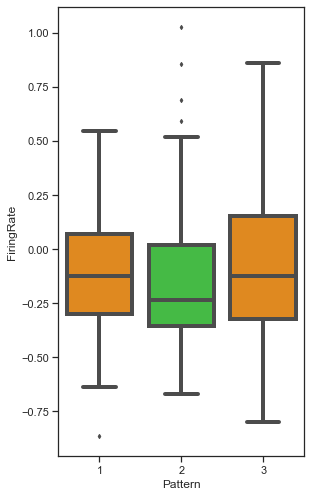

In [37]:
### Boxplot
df_temp = pd.DataFrame()
df_temp = df_spindle_firing.melt(id_vars=['name', 'Pattern', 'epochID'], var_name='subEpoch', value_name='FiringRate')
x = df_temp
sns.set(rc={'figure.figsize':(4.4,8.27)})
sns.set_style("ticks")
g=sns.boxplot(x="Pattern", y="FiringRate",dodge=False,fliersize=3,palette=['darkorange','limegreen','darkorange'],linewidth=4,data=x )
#g=sns.boxplot(x="Pattern", y="FiringRate",dodge=False,fliersize=3,palette=['darkorange','royalblue','darkorange'],linewidth=4,data=x )

#g.set_xticklabels(['SWSn','REM','SWSn.1'])
#plt.ylim(0,0.2)
#plt.ylim(0.05,0.07)
if save_file:
  #  df_spindle_firing.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type3_fr/900-10000frames_sws_awake_sws/frontal_electrode/spindle/Type3_fr_based_on_top20%_spindle_active.csv')
    #df_spindle_firing.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type3_fr/sws_rem_sws/frontal_electrode/spindle/20%/Type3_fr_based_on_top20%_spindle_active.csv')
        df_spindle_firing.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type3_fr/prova.csv')


#if save_fig:
 #   plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type3_fr/all_mice_sws_awake_sws_900_10000/frontal_electrode/spindle/Type3_fr_based_on_top20%_spindle_active.pdf', dpi=600, format='pdf')
        #plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type3_fr/all_mice_sws_rem_sws/frontal_electrode/spindle_coupled/Type3_fr_based_on_top20%_spindle_active.pdf', dpi=600, format='pdf')

### Triplet 3 frequency based on least x% of spindle (inactive) not divided to n

In [146]:
##frequency without levels

# plotting average firing rate 

df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (not isinstance(indDict['type3'], int)) and (len(indDict['spi_osc_data'])):
        for ii in range(3):
            df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'FiringRate':[np.nanmean(data_list[indDict['type3'][ii]]['avg_firing_perSecond_zscore'][data_list[indDict['type3'][0]]['spindle_least20_diff_firing'][0]])], 
                                                                 'name':indDict['mouseName'], 
                                                                 'Pattern': ii + 1, 
                                                                 'epochID': i}), ignore_index = True)
    

C:\Users\admin\AppData\Local\Temp/ipykernel_8476/1694730460.py:11: RuntimeWarning: Mean of empty slice
  df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'FiringRate':[np.nanmean(data_list[indDict['type3'][ii]]['avg_firing_perSecond_zscore'][data_list[indDict['type3'][0]]['spindle_least20_diff_firing'][0]])],


C:\Users\admin\AppData\Local\Temp/ipykernel_8476/2771261656.py:3: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_temp = df_spindle_firing.melt(id_vars=['name', 'Pattern', 'epochID'], var_name='subEpoch', value_name='FiringRate')


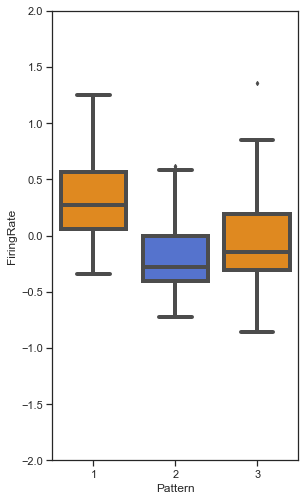

In [147]:
### Boxplot
df_temp = pd.DataFrame()
df_temp = df_spindle_firing.melt(id_vars=['name', 'Pattern', 'epochID'], var_name='subEpoch', value_name='FiringRate')
sns.set(rc={'figure.figsize':(4.4,8.27)})
sns.set_style("ticks")
#g=sns.boxplot(x="Pattern", y="FiringRate",dodge=False,fliersize=3,palette=['darkorange','limegreen','darkorange'],linewidth=4,data=x )
g=sns.boxplot(x="Pattern", y="FiringRate",dodge=False,fliersize=3,palette=['darkorange','royalblue','darkorange'],linewidth=4,data=df_temp )

#g.set_xticklabels(['SWSn','REM','SWSn.1'])
#plt.ylim(0,0.2)
#plt.ylim(0.05,0.07)
plt.ylim(-2,2)
if save_file:
  #  df_spindle_firing.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type3_fr/900-10000frames_sws_awake_sws/frontal_electrode/spindle/Type3_fr_based_on_least20%_spindle_active.csv')
    df_spindle_firing.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type3_fr_z_score/sws_rem_sws/frontal_electrode/spindle/20%/Type3_fr_based_on_least20%_spindle_active.csv')

if save_fig:
 #   plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type3_fr/all_mice_sws_awake_sws_900_10000/frontal_electrode/spindle/Type3_fr_based_on_least20%_spindle_active.pdf', dpi=600, format='pdf')
      plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type3_fr_z_score/all_mice_sws_rem_sws/frontal_electrode/spindle/Type3_fr_based_on_least20%_spindle_active.pdf', dpi=600, format='pdf')

### Frequency divided in thirds spindle active cells

In [ ]:
# plotting average firing rate 

df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (not isinstance(indDict['type3'], int)) and (len(indDict['spi_osc_data'])):
        for ii in range(3):
            df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'1th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][0][data_list[indDict['type3'][0]]['spindle_top20_diff_firing'][0]])], 
                                                                       '2th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][1][data_list[indDict['type3'][0]]['spindle_top20_diff_firing'][0]])], 
                                                                       '3th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][2][data_list[indDict['type3'][0]]['spindle_top20_diff_firing'][0]])], 
                                                                       'name':indDict['mouseName'], 
                                                                       'Pattern': ii+1,                                                                        
                                                                       'epochID': i}), ignore_index = True)

                                                                       

In [ ]:
df_temp = pd.DataFrame()
df_temp = df_spindle_firing.melt(id_vars=['name', 'Pattern', 'epochID'], var_name='Levels', value_name='firing_rate')
df_temp
myGrid = sns.FacetGrid(data=df_temp, col='Pattern', col_wrap=3, aspect=1, ylim=[0, 0.2])
#myplot = myGrid.map(sns.boxplot, 'Levels', 'firing_rate' ,fliersize=3,linewidth=4, palette=['darkorange','royalblue','darkorange'])
myplot = myGrid.map(sns.boxplot, 'Levels', 'firing_rate' ,fliersize=3,linewidth=4, palette=['darkorange','limegreen','darkorange'])

#if save_file:
 #   df_temp.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type3_fr/900-10000frames_sws_awake_sws/frontal_electrode/spindle_coupled/Type3_fr_boxplot_spindle_coupled_active_with_levels.csv')
#if save_fig:
 #   plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type3_fr/all_mice_sws_awake_sws_900_10000/frontal_electrode/spindle_coupled/Type3_fr_boxplot_spindle_coupled_active_with_levels.pdf', dpi=600, format='pdf')

### Frequency divided in thirds spindle inactive cells


In [ ]:
# plotting average firing rate 

df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (not isinstance(indDict['type3'], int)) and (len(indDict['spi_osc_data'])):
        for ii in range(3):
            df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'1th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][0][data_list[indDict['type3'][0]]['spindle_least20_diff_firing'][0]])], 
                                                                       '2th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][1][data_list[indDict['type3'][0]]['spindle_least20_diff_firing'][0]])], 
                                                                       '3th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][2][data_list[indDict['type3'][0]]['spindle_least20_diff_firing'][0]])], 
                                                                       'name':indDict['mouseName'], 
                                                                       'Pattern': ii+1,                                                                        
                                                                       'epochID': i}), ignore_index = True)

                                                                       

In [ ]:
df_temp = pd.DataFrame()
df_temp = df_spindle_firing.melt(id_vars=['name', 'Pattern', 'epochID'], var_name='Levels', value_name='firing_rate')
df_temp
myGrid = sns.FacetGrid(data=df_temp, col='Pattern', col_wrap=3, aspect=1, ylim=[0, 0.2])
#myplot = myGrid.map(sns.boxplot, 'Levels', 'firing_rate' ,fliersize=3,linewidth=4, palette=['darkorange','royalblue','darkorange'])
myplot = myGrid.map(sns.boxplot, 'Levels', 'firing_rate' ,fliersize=3,linewidth=4, palette=['darkorange','limegreen','darkorange'])

#if save_file:
 #   df_temp.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type3_fr/900-10000frames_sws_awake_sws/frontal_electrode/spindle_coupled/Type3_fr_boxplot_spindle_coupled_inactive_with_levels.csv')
#if save_fig:
 #   plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type3_fr/all_mice_sws_awake_sws_900_10000/frontal_electrode/spindle_coupled/Type3_fr_boxplot_spindle_coupled_inactive_with_levels.pdf', dpi=600, format='pdf')

### here

### Frequency based on top x% (first element) of spindle active divided to n

In [ ]:
# NEW

df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (not isinstance(indDict['type3'], int)) and (len(indDict['spi_osc_data'])):
        for ii in range(3):
            df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'1th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][0][data_list[indDict['type3'][0]]['spindle_top20_diff_firing'][0]])], 
                                                                       '2th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][1][data_list[indDict['type3'][0]]['spindle_top20_diff_firing'][0]])], 
                                                                       '3th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][2][data_list[indDict['type3'][0]]['spindle_top20_diff_firing'][0]])], 
                                                                       'name':indDict['mouseName'], 
                                                                       'Pattern': ii+1, 
                                                                       'epochID': i}), ignore_index = True)
    


C:\Users\admin\AppData\Local\Temp/ipykernel_9648/3777433627.py:9: RuntimeWarning: Mean of empty slice
  df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'1th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][0][data_list[indDict['type3'][0]]['spindle_top20_diff_firing'][0]])],
C:\Users\admin\AppData\Local\Temp/ipykernel_9648/3777433627.py:11: RuntimeWarning: Mean of empty slice
  '3th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][2][data_list[indDict['type3'][0]]['spindle_top20_diff_firing'][0]])],
C:\Users\admin\AppData\Local\Temp/ipykernel_9648/3777433627.py:10: RuntimeWarning: Mean of empty slice
  '2th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][1][data_list[indDict['type3'][0]]['spindle_top20_diff_firing'][0]])],


C:\Users\admin\Anaconda3\envs\sleep_project\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


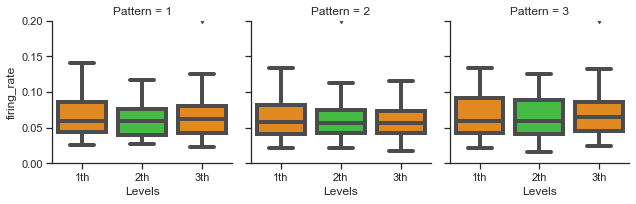

In [ ]:
df_temp = pd.DataFrame()
df_temp = df_spindle_firing.melt(id_vars=['name', 'Pattern', 'epochID'], var_name='Levels', value_name='firing_rate')
df_temp
myGrid = sns.FacetGrid(data=df_temp, col='Pattern', col_wrap=3, aspect=1, ylim=[0, 0.2])
#myplot = myGrid.map(sns.boxplot, 'Levels', 'firing_rate' ,fliersize=3,linewidth=4, palette=['darkorange','royalblue','darkorange'])
myplot = myGrid.map(sns.boxplot, 'Levels', 'firing_rate' ,fliersize=3,linewidth=4, palette=['darkorange','limegreen','darkorange'])

#if save_file:
  #  df_temp.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type3_fr/900-10000frames_sws_awake_sws/frontal_electrode/spindle_coupled/Type3_fr_boxplot_spindle_coupled_active_with_levels.csv')
#if save_fig:
  #  plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type3_fr/all_mice_sws_awake_sws_900_10000/frontal_electrode/spindle_coupled/Type3_fr_boxplot_spindle_coupled_active_with_levels.pdf', dpi=600, format='pdf')

### Frequency based on least x% of spindle (inactive) divided to n

In [ ]:
# plotting average firing rate 

df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (not isinstance(indDict['type3'], int)) and (len(indDict['spi_osc_data'])):
        for ii in range(3):
            df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'1th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][0][data_list[indDict['type3'][0]]['spindle_least20_diff_firing'][0]])], 
                                                                       '2th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][1][data_list[indDict['type3'][0]]['spindle_least20_diff_firing'][0]])], 
                                                                       '3th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][2][data_list[indDict['type3'][0]]['spindle_least20_diff_firing'][0]])], 
                                                                       'name':indDict['mouseName'], 
                                                                       'Pattern': ii+1, 
                                                                       'epochID': i}), ignore_index = True)
    


C:\Users\admin\AppData\Local\Temp/ipykernel_9648/1735280890.py:11: RuntimeWarning: Mean of empty slice
  '3th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][2][data_list[indDict['type3'][0]]['spindle_least20_diff_firing'][0]])],
C:\Users\admin\AppData\Local\Temp/ipykernel_9648/1735280890.py:9: RuntimeWarning: Mean of empty slice
  df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'1th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][0][data_list[indDict['type3'][0]]['spindle_least20_diff_firing'][0]])],
C:\Users\admin\AppData\Local\Temp/ipykernel_9648/1735280890.py:10: RuntimeWarning: Mean of empty slice
  '2th':[np.nanmean(data_list[indDict['type3'][ii]]['div_avg_firing_perSecond'][1][data_list[indDict['type3'][0]]['spindle_least20_diff_firing'][0]])],


C:\Users\admin\Anaconda3\envs\sleep_project\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


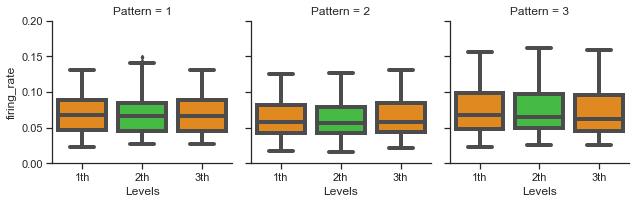

In [ ]:
df_temp = pd.DataFrame()
df_temp = df_spindle_firing.melt(id_vars=['name', 'Pattern', 'epochID'], var_name='Levels', value_name='firing_rate')
df_temp
myGrid = sns.FacetGrid(data=df_temp, col='Pattern', col_wrap=3, aspect=1, ylim=[0, 0.2])
#myplot = myGrid.map(sns.boxplot, 'Levels', 'firing_rate' ,fliersize=3,linewidth=4, palette=['darkorange','royalblue','darkorange'])
myplot = myGrid.map(sns.boxplot, 'Levels', 'firing_rate' ,fliersize=3,linewidth=4, palette=['darkorange','limegreen','darkorange'])

#if save_file:
  #  df_temp.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type3_fr/900-10000frames_sws_awake_sws/frontal_electrode/spindle_coupled/Type3_fr_boxplot_spindle_coupled_inactive_with_levels.csv')
#if save_fig:
  #  plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type3_fr/all_mice_sws_awake_sws_900_10000/frontal_electrode/spindle_coupled/Type3_fr_boxplot_spindle_coupled_inactive_with_levels.pdf', dpi=600, format='pdf')

### Fraction of the same spindle/SO active cells in 2 subsequent SWS epochs


In [ ]:
plt.hist(data_list[56]["data"].shape

In [ ]:
df_spindle_firing = pd.DataFrame()
old_spi_slo = []
old_index = []
old_mouse_name = []

for i, indDict in enumerate(data_list):
    
    if (not isinstance(indDict['type3'], int)) and (len(indDict['spi_osc_data'])) and len(indDict['spi_osc_data']):
        
        if len(data_list[indDict['type3'][2]]['spi_osc_data']):
            
            if len(old_spi_slo):
                #pdb.set_trace()
                new_spi_slo = []
                new_spi_slo = data_list[indDict['type3'][2]]['spindle_top20_diff_firing'][0]
                fraction = len([rr for rr in old_spi_slo if rr in new_spi_slo]) / len(old_spi_slo)

                df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'fraction':[fraction],
                                                                     'name':old_mouse_name, 
                                                                     'epochID': old_index}), ignore_index = True)

                old_spi_slo = new_spi_slo
                old_index = i
                old_mouse_name = indDict['mouseName']


            else:
                old_spi_slo = indDict['spindle_top20_diff_firing'][0]
                old_index = i
                old_mouse_name = indDict['mouseName']
        

C:\Users\admin\Anaconda3\envs\sleep_project\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 6.0)

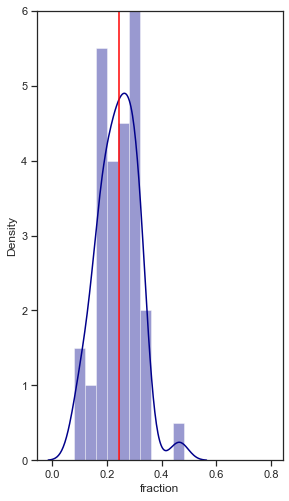

In [ ]:
plt.rcParams["patch.force_edgecolor"] = True

sns.distplot(df_spindle_firing["fraction"],color='darkblue', bins = 20,hist=True, hist_kws={"range": [0.,0.8]})
plt.axvline(x=df_spindle_firing.fraction.median(),
            color='red')
plt.ylim(0,6)



(0.0, 0.6)

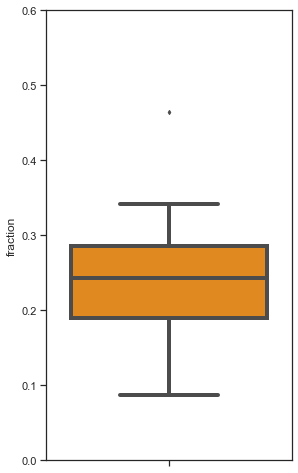

In [ ]:
sns.boxplot(y="fraction", data=df_spindle_firing,dodge=False,fliersize=3,color='darkorange',linewidth=4)
plt.ylim(0,.6)
#if save_file:
 #   df_temp.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type3_fr/Type3_fr_based_on_top20%_divided_thirds_slo_active.csv')

#### Frquency Type 4

#### Frequency based on top x% of sindle active

In [ ]:
# plotting average firing rate 

df_typ4_firing = pd.DataFrame()

    
for i, data_dict in enumerate(data_list):
    if not isinstance(data_dict['type4'], int) and (len(data_list[i+1]['spi_osc_data'])):
        df_typ4_firing = df_typ4_firing.append(pd.DataFrame({'First':[np.nanmean(data_list[data_dict['type4'][0]]['avg_firing_perSecond'][data_list[data_dict['type4'][1]]['spindle_top20_diff_firing'][0]])],
                                                             'Second':[np.nanmean(data_list[data_dict['type4'][1]]['avg_firing_perSecond'][data_list[data_dict['type4'][1]]['spindle_top20_diff_firing'][0]])],
                                                             'Third':[np.nanmean(data_list[data_dict['type4'][2]]['avg_firing_perSecond'][data_list[data_dict['type4'][1]]['spindle_top20_diff_firing'][0]])],
                                                             'Fourth':[np.nanmean(data_list[data_dict['type4'][3]]['avg_firing_perSecond'][data_list[data_dict['type4'][1]]['spindle_top20_diff_firing'][0]])],
                                                             'name':data_dict['mouseName'], 
                                                             'epochID': i}), ignore_index = True)
    


In [ ]:
# plotting average firing rate 

df_typ4_firing = pd.DataFrame()

    
for i, data_dict in enumerate(data_list):
    if not isinstance(data_dict['type4'], int) and (len(data_list[i+1]['spi_osc_data'])):
        df_typ4_firing = df_typ4_firing.append(pd.DataFrame({'First':[np.nanmean(data_list[data_dict['type4'][0]]['avg_firing_perSecond'][data_list[data_dict['type4'][1]]['spindle_top20_diff_firing'][0]])],
                                                             'Second':[np.nanmean(data_list[data_dict['type4'][1]]['avg_firing_perSecond'][data_list[data_dict['type4'][1]]['spindle_top20_diff_firing'][0]])],
                                                             'Third':[np.nanmean(data_list[data_dict['type4'][2]]['avg_firing_perSecond'][data_list[data_dict['type4'][1]]['spindle_top20_diff_firing'][0]])],
                                                             'Fourth':[np.nanmean(data_list[data_dict['type4'][3]]['avg_firing_perSecond'][data_list[data_dict['type4'][1]]['spindle_top20_diff_firing'][0]])],
                                                             'name':data_dict['mouseName'], 
                                                             'epochID': i}), ignore_index = True)
    

In [ ]:
df_typ4_firing

In [ ]:
### Boxplot
df_temp = pd.DataFrame()
df_temp = df_typ4_firing.melt(id_vars=['name', 'epochID'], var_name='Pattern', value_name='FiringRate')

sns.set(rc={'figure.figsize':(4.4,8.27)})
sns.set_style("ticks")
g=sns.boxplot(x="Pattern", y="FiringRate",dodge=False,fliersize=3,palette=['limegreen','darkorange','limegreen','darkorange'],linewidth=4,data=df_temp )
plt.ylim(0,0.2)
if save_file:
    df_temp.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type4_fr/Type4_fr_spindle_coupled_active_awake_sws_awake_sws.csv')
if save_fig:
    plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type4_fr/awake_sws_awake_sws/Type4_fr_divided_thirds_boxplot_spindle_coupled_active.pdf', dpi=300, format='pdf')

In [ ]:
df_temp = pd.DataFrame()
df_temp = df_typ4_firing.melt(id_vars=['name', 'epochID'], var_name='Pattern', value_name='FiringRate')

plt.figure(figsize=(10,7))
sns.violinplot(data=df_temp, y='FiringRate', x = 'name', hue='Pattern')
plt.ylim([-.05, 0.4])
#if save_file:
 #   df_temp.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type4_fr/Type4_fr_based_on_top_20%_spindle_active.csv')
#if save_fig:
    plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type4_fr/awake_sws_awake_sws/Type4_fr_based_on_top_20%_spindle_active.pdf', dpi=300, format='pdf')

#### Frequency based on least x% of sindle active

In [ ]:
###test####
df_typ4_firing = pd.DataFrame()


for i, indDict in enumerate (data_list):
    if not isinstance(indDict['type4'], int):
        for ii in range(4):
            df_typ4_firing = df_typ4_firing.append(pd.DataFrame({'spi_osc_data':[np.nanmean(data_list[indDict['type4'][ii]]['avg_firing_perSecond'])], 
                                                                 'name':indDict['mouseName'], 
                                                                 'Pattern': ii + 1, 
                                                                 'epochID': i}), ignore_index = True)

In [ ]:
df_typ4_firing.shape

In [ ]:
# plotting average firing rate 

df_typ4_firing = pd.DataFrame()

    
for i, data_dict in enumerate(data_list):
    if not isinstance(data_dict['type4'], int) and (len(data_list[i+1]['spi_osc_data'])):
        df_typ4_firing = df_typ4_firing.append(pd.DataFrame({'First':[np.nanmean(data_list[data_dict['type4'][0]]['avg_firing_perSecond'][data_list[data_dict['type4'][1]]['spindle_least20_diff_firing'][0]])],
                                                             'Second':[np.nanmean(data_list[data_dict['type4'][1]]['avg_firing_perSecond'][data_list[data_dict['type4'][1]]['spindle_least20_diff_firing'][0]])],
                                                             'Third':[np.nanmean(data_list[data_dict['type4'][2]]['avg_firing_perSecond'][data_list[data_dict['type4'][1]]['spindle_least20_diff_firing'][0]])],
                                                             'Fourth':[np.nanmean(data_list[data_dict['type4'][3]]['avg_firing_perSecond'][data_list[data_dict['type4'][1]]['spindle_least20_diff_firing'][0]])],
                                                             'name':data_dict['mouseName'], 
                                                             'epochID': i}), ignore_index = True)
    

In [ ]:
### Boxplot
df_temp = pd.DataFrame()
df_temp = df_typ4_firing.melt(id_vars=['name', 'epochID'], var_name='Pattern', value_name='FiringRate')

sns.set(rc={'figure.figsize':(4.4,8.27)})
sns.set_style("ticks")
g=sns.boxplot(x="Pattern", y="FiringRate",dodge=False,fliersize=3,palette=['limegreen','darkorange','limegreen','darkorange'],linewidth=4,data=df_temp )
plt.ylim(0,0.2)
if save_file:
    df_temp.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type4_fr/Type4_fr_spindle_coupled_inactive_awake_sws_awake_sws.csv')
if save_fig:
    plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type4_fr/awake_sws_awake_sws/Type4_fr_divided_thirds_boxplot_spindle_coupled_inactive.pdf', dpi=300, format='pdf')

In [ ]:
df_temp = pd.DataFrame()
df_temp = df_typ4_firing.melt(id_vars=['name', 'epochID'], var_name='Pattern', value_name='FiringRate')

plt.figure(figsize=(10,7))
sns.violinplot(data=df_temp, y='FiringRate', x = 'name', hue='Pattern')
plt.ylim([-.05, 0.4])
#if save_file:
  #  df_temp.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type4_fr/Type4_fr_based_on_least_20%_spindle_active.csv')
#if save_fig:
   # plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type4_fr/Type4_fr_based_on_least_20%_spindle_active.pdf', dpi=300, format='pdf')

#### Frequency based on top x% spindle active divided to n

In [ ]:
# plotting average firing rate 

df_typ4_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if not isinstance(indDict['type4'], int) and (len(data_list[i+1]['spi_osc_data'])):
        for ii in range(4):
            df_typ4_firing = df_typ4_firing.append(pd.DataFrame({'1th':[np.nanmean(data_list[indDict['type4'][ii]]['div_avg_firing_perSecond'][0][data_list[indDict['type4'][1]]['spindle_top20_diff_firing'][0]])], 
                                                                 '2th':[np.nanmean(data_list[indDict['type4'][ii]]['div_avg_firing_perSecond'][1][data_list[indDict['type4'][1]]['spindle_top20_diff_firing'][0]])], 
                                                                 '3th':[np.nanmean(data_list[indDict['type4'][ii]]['div_avg_firing_perSecond'][2][data_list[indDict['type4'][1]]['spindle_top20_diff_firing'][0]])], 
                                                                 'name':indDict['mouseName'], 
                                                                 'Pattern': ii+1,
                                                                 'epochID': i}), ignore_index = True)
    


In [ ]:
df_temp = pd.DataFrame()
df_temp = df_typ4_firing.melt(id_vars=['name', 'Pattern', 'epochID'], var_name='levels', value_name='firing_rate')
#x=df_temp.groupby(["name","Pattern","subEpoch"], as_index=False).agg({"firing_rate": np.mean})
x = df_temp.groupby(by = ["Pattern","levels"], as_index=False).agg(np.median)
#x = df_temp[df_temp.Pattern == 1].groupby(by = ["subEpoch", "Pattern"], as_index=False).agg(np.median)
#myGrid = sns.FacetGrid(data=x, aspect=4, ylim=[-.05, 0.3])
#myplot = myGrid.map(sns.violinplot, 'Pattern', 'firing_rate', 'subEpoch')
#myplot.add_legend()
#if save_fig:
   # plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type3_fr/Type3_fr_divided_thirds.pdf', dpi=300, format='pdf')

#sns.lineplot(x="Pattern", y="firing_rate", hue= "subEpoch",err_style='bars', data=x)
#sns.pointplot(x="Pattern", y="firing_rate", hue= "subEpoch", ylim=[1, 2],data=x)
#sns.violinplot(x="Pattern", y="firing_rate", hue="subEpoch",data=x )
sns.set(rc={'figure.figsize':(4.4,8.27)})
sns.set_style("ticks")
g=sns.barplot(x="Pattern", y="firing_rate",color="Grey",data=x )
g.set_xticklabels(['Awake','SWSn','REM','SWSn.1'])

#sns.catplot(x="Pattern", y="firing_rate", hue= "subEpoch",kind="point",height=6, aspect=.75,data=x)
#g=sns.PairGrid(x,y_vars="firing_rate",x_vars=["SWSn", "REM", "SWSn+1", ],
             #height=5, aspect=.5)
#if save_fig:
 #   plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type4_fr/Type4_fr_divided_thirds_active_spindle_coupled_bar_plot.pdf', dpi=300, format='pdf')

In [ ]:
###choose pattern to plot####
df_temp = pd.DataFrame()
df_temp = df_typ4_firing.melt(id_vars=['name', 'Pattern', 'epochID'], var_name='levels', value_name='firing_rate')
x = df_temp[df_temp.Pattern == 4].groupby(by = ["levels", "Pattern"], as_index=False).agg(np.median)
ax = plt.gca()
#ax.set_facecolor('xkcd:salmon')
#ax.set_facecolor((1, 0.47, 0.42)) ####REM####
#ax.set_facecolor((0.4,0.6,0.7)) ####SWS####
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set()
sns.set(rc={'figure.figsize':(4.4,8.27)})
sns.set_style("ticks")

g=sns.lineplot(x="levels", y="firing_rate", style="Pattern",color='blue',markers=True,err_style='band',legend = False, data=x)
g.set_xticklabels(['1st','2nd','3rd'])
g.set_title('SWSn+1')
g.set(xlabel='levels', ylabel='Mean Frequency Rate')
#g.sns.set_style("whitegrid", {'axes.grid' : False})
#plt.ylim(0.045,0.062)
plt.ylim(0.04,0.13)

if save_fig:
    plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type4_fr/Type4_fr_divided_thirds_swsn.1_spindle_coupled_active.pdf', dpi=300, format='pdf')

In [ ]:
df_temp = pd.DataFrame()
df_temp = df_typ4_firing.melt(id_vars=['name', 'Pattern', 'epochID'], var_name='levels', value_name='firing_rate')

myGrid = sns.FacetGrid(data=df_temp, col='name', col_wrap=2, aspect=2, ylim=[-.05, 0.6])
myplot = myGrid.map(sns.violinplot, 'Pattern', 'firing_rate', 'levels')
myplot.add_legend()
if save_file:
    df_temp.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type4_fr/Type4_fr_based_on_top_20%_divided_thirds_slo_active.csv')
if save_fig:
    plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type4_fr/Type4_fr_based_on_top_20%_divided_thirds_slo_active.pdf', dpi=300, format='pdf')

#### Frequency based on least x% spindle active divided to n

In [ ]:
# plotting average firing rate 

df_typ4_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if not isinstance(indDict['type4'], int) and (len(data_list[i+1]['spi_osc_data'])):
        for ii in range(4):
            df_typ4_firing = df_typ4_firing.append(pd.DataFrame({'1th':[np.nanmean(data_list[indDict['type4'][ii]]['div_avg_firing_perSecond'][0][data_list[indDict['type4'][1]]['spindle_least20_diff_firing'][0]])], 
                                                                 '2th':[np.nanmean(data_list[indDict['type4'][ii]]['div_avg_firing_perSecond'][1][data_list[indDict['type4'][1]]['spindle_least20_diff_firing'][0]])], 
                                                                 '3th':[np.nanmean(data_list[indDict['type4'][ii]]['div_avg_firing_perSecond'][2][data_list[indDict['type4'][1]]['spindle_least20_diff_firing'][0]])], 
                                                                 'name':indDict['mouseName'], 
                                                                 'Pattern': ii+1,
                                                                 'epochID': i}), ignore_index = True)
    

In [ ]:
df_temp = pd.DataFrame()
df_temp = df_typ4_firing.melt(id_vars=['name', 'Pattern', 'epochID'], var_name='levels', value_name='firing_rate')
#x=df_temp.groupby(["name","Pattern","subEpoch"], as_index=False).agg({"firing_rate": np.mean})
x = df_temp.groupby(by = ["Pattern","levels"], as_index=False).agg(np.median)
#x = df_temp[df_temp.Pattern == 1].groupby(by = ["subEpoch", "Pattern"], as_index=False).agg(np.median)
#myGrid = sns.FacetGrid(data=x, aspect=4, ylim=[-.05, 0.3])
#myplot = myGrid.map(sns.violinplot, 'Pattern', 'firing_rate', 'subEpoch')
#myplot.add_legend()
#if save_fig:
   # plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type3_fr/Type3_fr_divided_thirds.pdf', dpi=300, format='pdf')

#sns.lineplot(x="Pattern", y="firing_rate", hue= "subEpoch",err_style='bars', data=x)
#sns.pointplot(x="Pattern", y="firing_rate", hue= "subEpoch", ylim=[1, 2],data=x)
#sns.violinplot(x="Pattern", y="firing_rate", hue="subEpoch",data=x )
sns.set(rc={'figure.figsize':(4.4,8.27)})
sns.set_style("ticks")
g=sns.barplot(x="Pattern", y="firing_rate",color="Grey",data=x )
g.set_xticklabels(['Awake','SWSn','REM','SWSn.1'])

#sns.catplot(x="Pattern", y="firing_rate", hue= "subEpoch",kind="point",height=6, aspect=.75,data=x)
#g=sns.PairGrid(x,y_vars="firing_rate",x_vars=["SWSn", "REM", "SWSn+1", ],
             #height=5, aspect=.5)
if save_fig:
    plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type4_fr/Type4_fr_divided_thirds_inactive_spindle_coupled_bar_plot.pdf', dpi=300, format='pdf')

In [ ]:
###choose pattern to plot####
df_temp = pd.DataFrame()
df_temp = df_typ4_firing.melt(id_vars=['name', 'Pattern', 'epochID'], var_name='levels', value_name='firing_rate')
x = df_temp[df_temp.Pattern == 4].groupby(by = ["levels", "Pattern"], as_index=False).agg(np.median)
ax = plt.gca()
#ax.set_facecolor('xkcd:salmon')
#ax.set_facecolor((1, 0.47, 0.42)) ####REM####
#ax.set_facecolor((0.4,0.6,0.7)) ####SWS####
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set()
sns.set(rc={'figure.figsize':(4.4,8.27)})
sns.set_style("ticks")

g=sns.lineplot(x="levels", y="firing_rate", style="Pattern",color='blue',markers=True,err_style='band',legend = False, data=x)
g.set_xticklabels(['1st','2nd','3rd'])
g.set_title('SWSn+1')
g.set(xlabel='levels', ylabel='Mean Frequency Rate')
#g.sns.set_style("whitegrid", {'axes.grid' : False})
#plt.ylim(0.045,0.062)
plt.ylim(0.04,0.15)

if save_fig:
    plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type4_fr/Type4_fr_divided_thirds_swsn.1_spindle_coupled_inactive.pdf', dpi=300, format='pdf')

In [ ]:
df_temp = pd.DataFrame()
df_temp = df_typ4_firing.melt(id_vars=['name', 'Pattern', 'epochID'], var_name='levels', value_name='firing_rate')

myGrid = sns.FacetGrid(data=df_temp, col='name', col_wrap=2, aspect=2, ylim=[-.05, 0.6])
myplot = myGrid.map(sns.violinplot, 'Pattern', 'firing_rate', 'levels')
myplot.add_legend()
if save_file:
    df_temp.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/Triplet_type4_fr/Type4_fr_based_on_least_20%_divided_thirds_spindle_active.csv')
if save_fig:
    plt.savefig(fig_save_add + 'L:/analysis_nima/epoch_based_analysis/Triplet_type4_fr/Type4_fr_based_on_least_20%_divided_thirds_spindle_active.pdf', dpi=300, format='pdf')

### Read and write data as JSON file

In [ ]:
with open('I:/Marco/analysis_nima/allData_JSON/fullData_with_analyses.json', 'w') as wr:
    json.dump(data_list , wr, cls=NumpyEncoder)

In [ ]:
with open(r"I:/Marco/analysis_nima/allData_JSON/fullData_with_analyses.json", "r") as read_file:
    data_list = json.load(read_file)

In [ ]:
# change lists to array
[data_dict.update({key: np.asarray(data_dict[key])}) for data_dict in data_list for key in data_dict.keys() if isinstance(data_dict[key], list)];